# Local Voting vs College Polarity
Author: Rishabh Garg

In this notebook we seek to analyze how the polarity of a college impacts the voting patterns of a county during the 2020 presedential elections. To understand the significance, we used OLS Regression and data from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FVOQCHQ.

In [25]:
# Input Information
YEAR = 2020
AVERAGE = False # True if you want to average the polarity since the last election

In [26]:
# Imports
import numpy as np
import pandas as pd
from plotnine import *
from plotnine.data import mpg
import statsmodels.api as sm

In [27]:
# Read CSV Files
df = pd.read_csv('../../data/College Records - college-counties-2020.csv')
cvd = pd.read_csv('../../data/countypres_2000-2020.csv')

In [28]:
# Clean input data to remove nulls and reset index
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [29]:
# Merge liberal and conservative votes in County Voting Data
cvd = cvd[cvd['party']!="OTHER"]
cvd = cvd.reset_index(drop=True)
PARTY_REPLACEMENTS = {"LIBERAL": ["DEMOCRAT", "GREEN"], "CONSERVATIVE": ["REPUBLICAN", "LIBERTARIAN"]}
for party, replacements in PARTY_REPLACEMENTS.items():
    cvd.loc[cvd['party'].isin(replacements), 'party'] = party
grouped = cvd.groupby(['year','state','county_name', 'party', 'totalvotes'], as_index=False)
cvd = grouped.agg({'candidatevotes':'sum'})
cvd.dropna(inplace=True)

In [30]:
# Calculate county voting percents
liberal_percents = []
conservative_percents = []
for i in range(len(df)):
    county = df.iloc[i]['County'].upper()
    state = df.iloc[i]['State'].upper()
    # Get the total votes and candidate votes for liberals and conservatives in cvd using the county, state, and year
    county = df.iloc[i]['County'].upper()
    state = df.iloc[i]['State'].upper()
    liberal_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='LIBERAL')]['candidatevotes'].sum()
    conservative_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='CONSERVATIVE')]['candidatevotes'].sum()
    total_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='LIBERAL')]['totalvotes'].sum()
    liberal_percent = liberal_votes / total_votes
    conservative_percent = conservative_votes / total_votes
    liberal_percents.append(liberal_percent)
    conservative_percents.append(conservative_percent)
df["Liberal Percents"] = liberal_percents
df["Conservative Percents"] = conservative_percents

In [31]:
if AVERAGE: 
    plot_df = pd.DataFrame(columns=["College Polarity Score from 2016-2019", "Liberal Proportion of Votes in 2020 Election"])
    # Average Data for 4 years
    for row in df.iterrows():
        scores = [row[1][str(i)] for i in range(YEAR-4, YEAR)]
        average = np.mean(scores)
        plot_df.loc[len(plot_df)] = [average, row[1]["Liberal Percents"]]
else:
    plot_df = pd.DataFrame(columns=["College Polarity Score in 2020 Election", "Liberal Proportion of Votes in 2020 Election"])
    for row in df.iterrows():
        plot_df.loc[len(plot_df)] = [row[1][str(YEAR)], row[1]["Liberal Percents"]]

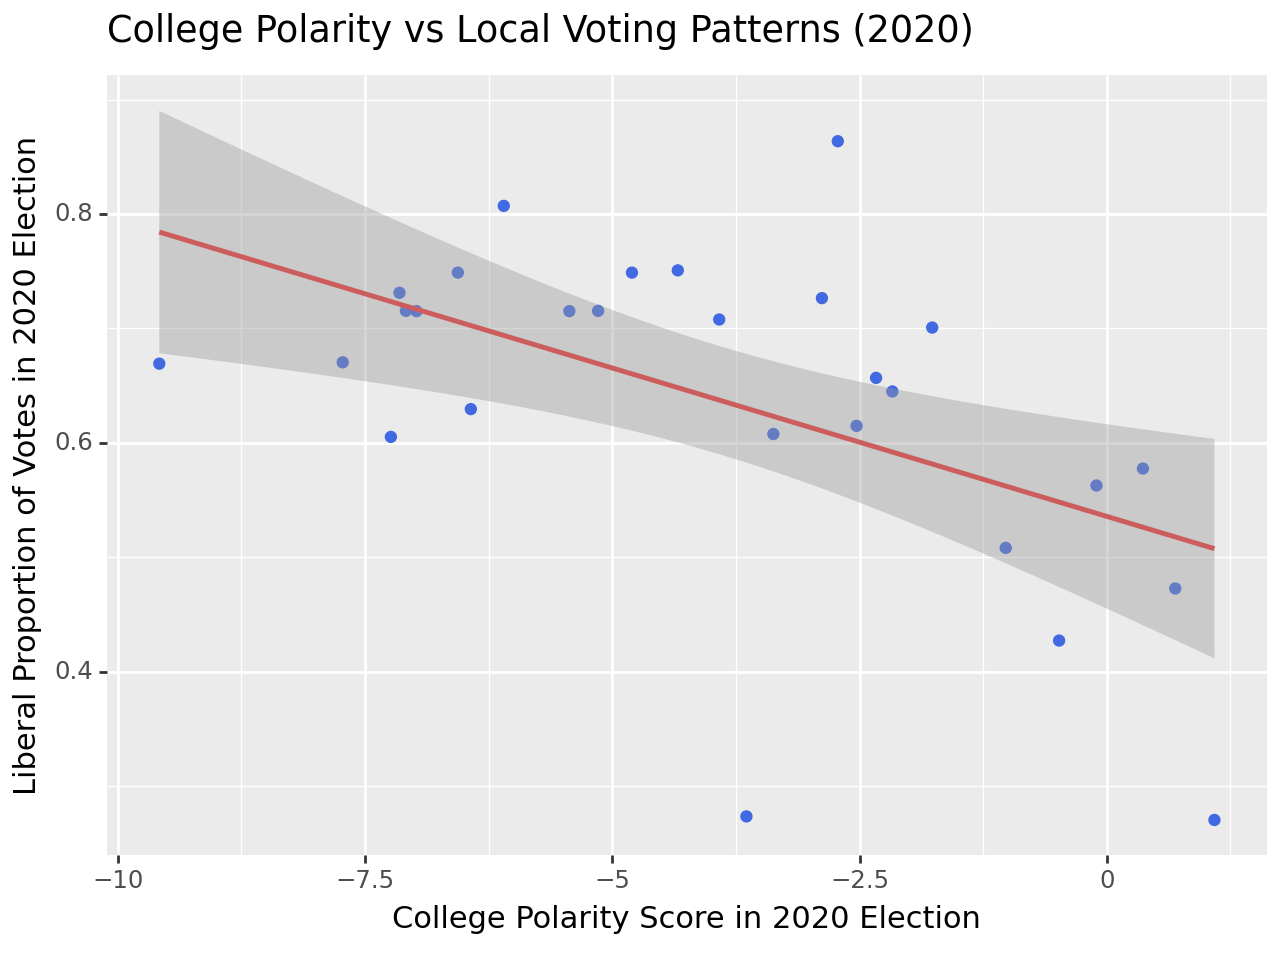

<Figure Size: (640 x 480)>

In [32]:
# Plot Data
if AVERAGE:
    x_string = "College Polarity Score from 2016-2019"
    title = "College Polarity vs Local Voting Patterns (Averaged)"
else:
    x_string = "College Polarity Score in 2020 Election"
    title = "College Polarity vs Local Voting Patterns (2020)"
x = plot_df[x_string]
y = plot_df["Liberal Proportion of Votes in 2020 Election"]
plot = (ggplot(plot_df, aes(x_string, 'Liberal Proportion of Votes in 2020 Election'))
 + geom_point(color = 'royalblue')
 + ggtitle(title)
 + stat_smooth(method='lm', color='indianred'))
plot

In [33]:
# Data scoring
x = plot_df[[x_string]]
y = plot_df['Liberal Proportion of Votes in 2020 Election']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     Liberal Proportion of Votes in 2020 Election   R-squared:                       0.282
Model:                                                      OLS   Adj. R-squared:                  0.254
Method:                                           Least Squares   F-statistic:                     10.19
Date:                                          Sun, 30 Jul 2023   Prob (F-statistic):            0.00367
Time:                                                  19:48:13   Log-Likelihood:                 20.263
No. Observations:                                            28   AIC:                            -36.53
Df Residuals:                                                26   BIC:                            -33.86
Df Model:                                                     1                                         
Covariance Type:                                      nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.5357      0.039     13.667      0.000       0.455       0.616
College Polarity Score in 2020 Election    -0.0259      0.008     -3.192      0.004      -0.043      -0.009
==============================================================================
Omnibus:                        8.530   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                7.163
Skew:                          -0.883   Prob(JB):                       0.0278
Kurtosis:                       4.738   Cond. No.                         8.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""